# Ensemble/Voting Classification in Python with Scikit-Learn
ref：https://www.kaggle.com/c/titanic/submit

In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
training_data = pd.read_csv('data/train.csv')
testing_data = pd.read_csv('data/test.csv')
def get_nulls(training, testing):
    print("Training Data:")
    print(pd.isnull(training).sum())
    print("Testing Data:")
    print(pd.isnull(testing).sum())

get_nulls(training_data, testing_data)

Training Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [7]:
# Drop the cabin column, as there are too many missing values
# Drop the ticket numbers too, as there are too many categories
# Drop names as they won't really help predict survivors
training_data.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
testing_data.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

# Taking the mean/average value would be impacted by the skew
# so we should use the median value to impute missing values
training_data["Age"].fillna(training_data["Age"].median(),inplace=True)
training_data["Embarked"].fillna('S',inplace=True)
testing_data["Age"].fillna(testing_data["Age"].median(), inplace=True)
testing_data['Fare'].fillna(testing_data["Fare"].median(), inplace=True)

get_nulls(training_data, testing_data)

Training Data:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Testing Data:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


In [9]:
# Fit the encoder on the data (Feature: Sex)
encoder_1 = LabelEncoder()
encoder_1.fit(training_data["Sex"])

# Transform and replace training data
training_sex_encoded = encoder_1.transform(training_data["Sex"])
training_data["Sex"] = training_sex_encoded
test_sex_encoded = encoder_1.transform(testing_data["Sex"])
testing_data["Sex"] = test_sex_encoded

# Fit the encoder on the data (Feature: Embarked)
encoder_2 = LabelEncoder()
encoder_2.fit(training_data["Embarked"])
training_data["Embarked"] = encoder_2.transform(training_data["Embarked"])
testing_data["Embarked"] = encoder_2.transform(testing_data["Embarked"])

# Any value we want to reshape needs be turned into array first
ages_train = np.array(training_data["Age"]).reshape(-1, 1)
fares_train = np.array(training_data["Fare"]).reshape(-1, 1)
ages_test = np.array(testing_data["Age"]).reshape(-1, 1)
fares_test = np.array(testing_data["Fare"]).reshape(-1, 1)

# Scaler takes arrays
scaler = StandardScaler()

training_data["Age"] = scaler.fit_transform(ages_train)
training_data["Fare"] = scaler.fit_transform(fares_train)
testing_data["Age"] = scaler.fit_transform(ages_test)
testing_data["Fare"] = scaler.fit_transform(fares_test)

In [11]:
training_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,-0.565736,1,0,-0.502445,2
1,2,1,1,0,0.663861,1,0,0.786845,0
2,3,1,3,0,-0.258337,0,0,-0.488854,2
3,4,1,1,0,0.433312,1,0,0.420730,2
4,5,0,3,1,0.433312,0,0,-0.486337,2


In [12]:
# Now to select our training/testing data
X_features = training_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = training_data['Survived']

print(X_features.head(5))
print(y_labels.head(5))

# Make the train/test data from validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.1,random_state=12)

   Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0       3    1 -0.565736      1      0 -0.502445         2
1       1    0  0.663861      1      0  0.786845         0
2       3    0 -0.258337      0      0 -0.488854         2
3       1    0  0.433312      1      0  0.420730         2
4       3    1  0.433312      0      0 -0.486337         2
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


## Simple Averaging Approach

In [26]:
LogReg_clf = LogisticRegression()
DTree_clf = DecisionTreeClassifier()
SVC_clf = SVC()

LogReg_clf.fit(X_train, y_train)
DTree_clf.fit(X_train, y_train)
SVC_clf.fit(X_train, y_train)

LogReg_pred = LogReg_clf.predict(X_val)
DTree_pred = DTree_clf.predict(X_val)
SVC_pred = SVC_clf.predict(X_val)

averaged_preds = (LogReg_pred + DTree_pred + SVC_pred)/3
averaged_preds = [1 if i > 0.5 else 0 for i in averaged_preds]
acc = accuracy_score(y_val, averaged_preds)
print(acc)

0.8333333333333334


## Bagging Classification Example

In [31]:
logreg_bagging_model = BaggingClassifier(base_estimator=LogReg_clf, n_estimators=50, random_state=12)
dtree_bagging_model = BaggingClassifier(base_estimator=DTree_clf, n_estimators=50, random_state=12)
random_forest = RandomForestClassifier(n_estimators=50, random_state=12)
extra_trees = ExtraTreesClassifier(n_estimators=50, random_state=12)

def bagging_ensemble(model):
    k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
    results = cross_val_score(model, X_train, y_train, cv=k_folds)
    print(results.mean())

bagging_ensemble(logreg_bagging_model)
bagging_ensemble(dtree_bagging_model)
bagging_ensemble(random_forest)
bagging_ensemble(extra_trees)

0.7927134146341464
0.8188719512195123
0.8188719512195121
0.793871951219512


## Boosting Classification Example

In [36]:
k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
num_estimators = [20, 30, 40, 50, 60, 70, 80, 90, 100]

scores = []
for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators=i, random_state=12)
    results = cross_val_score(ada_boost, X_train, y_train, cv=k_folds)
    print("Results for {} estimators:".format(i))
    print(results.mean())
    scores.append(results.mean())

Results for 20 estimators:
0.8052134146341464
Results for 30 estimators:
0.8101829268292684
Results for 40 estimators:
0.8176524390243903
Results for 50 estimators:
0.8164024390243902
Results for 60 estimators:
0.8164329268292683
Results for 70 estimators:
0.8201524390243902
Results for 80 estimators:
0.8151524390243902
Results for 90 estimators:
0.8114024390243904
Results for 100 estimators:
0.8101524390243903


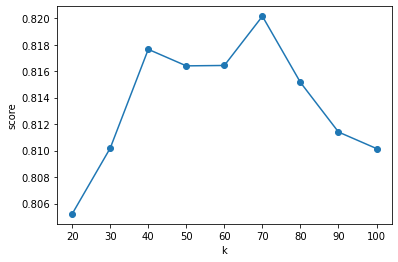

In [42]:
import matplotlib.pyplot as plt
plt.plot(num_estimators, scores, marker='o')
plt.xlabel('k')
plt.ylabel('score')
plt.show()

## voting\Stacking Classification Example

In [43]:
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='hard')
voting_clf.fit(X_train, y_train)
preds = voting_clf.predict(X_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

Accuracy is: 0.8222222222222222
Log Loss is: 6.140280221146135
F1 Score is: 0.7575757575757576


In [44]:
testing_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,0.386231,0,0,-0.497413,1
1,893,3,0,1.371370,1,0,-0.512278,2
2,894,2,1,2.553537,0,0,-0.464100,1
3,895,3,1,-0.204852,0,0,-0.482475,2
4,896,3,0,-0.598908,1,1,-0.417492,2
...,...,...,...,...,...,...,...,...
413,1305,3,1,-0.204852,0,0,-0.493455,2
414,1306,1,0,0.740881,0,0,1.314435,0
415,1307,3,1,0.701476,0,0,-0.507796,2
416,1308,3,1,-0.204852,0,0,-0.493455,2


In [45]:
test = testing_data.drop("PassengerId", axis=1)

In [48]:
submission_df = pd.DataFrame(columns=["PassengerId", "Survived"])
submission_df['PassengerId'] = testing_data["PassengerId"]
preds = voting_clf.predict(test)
submission_df['Survived'] = preds
submission_df.to_csv("submissions.csv", index=False, header=True)